# sDIC Decomposition

Decomposing sDIC via finite differencing to look at what influences its changes.

$$
\frac{dsDIC}{dt} = J^{\prime}_{circ} + J^{\prime}_{bio} + J^{\prime}_{ex}
$$

In [19]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import esmtools as et
import glob
import seaborn as sns
import pandas as pd

In [20]:
def load_variables(ebu):
    v_list = ['FG_CO2', 'Jint_100m_circ', 'Jint_100m_DIC', 'sDIC_int100m_tendency']
    basepath = '/glade/work/rbrady/EBUS_BGC_Variability/sDIC_decomposition/'
    ds = xr.Dataset()
    for name in v_list:
        filepath = (basepath + name + '/' + ebu + '/' + ebu.lower() +
                   '-' + name + '-residuals-AW-chavez-800km.nc')
        temp_ds = xr.open_dataarray(filepath)
        if name == 'FG_CO2' or name == 'Jint_100m_DIC':
            temp_ds = temp_ds.isel(ensemble=slice(1,34))
        ds = xr.merge([ds, temp_ds])
    return ds
    

In [21]:
def load_index(idx):
    if idx == 'NPGO':
        ds = xr.open_mfdataset('/glade/work/rbrady/EBUS_BGC_Variability/NPGO/*.nc', 
                              concat_dim='ensemble')
        ds = ds.isel(ensemble=slice(1,34))
        ds = ds['pc'].to_dataset()
        ds = ds.rename({'pc': 'NPGO'})
    else:
        ds = xr.open_dataset('/glade/work/rbrady/cesmLE_CVDP/processed/cvdp_detrended_BGC.nc')
        ds = ds[idx]
        ds = ds.isel(ensemble=slice(1,34))
    return ds

In [22]:
def regression(ds):
    m1, m2, m3, m4 = ([] for i in range(4))
    for label, group in ds.groupby('ensemble'):
        """
        The manually integrate
        """
        M1, _, _, _, _ = et.stats.linear_regression(group['index'], group['FG_CO2_AW'])
        M2, _, _, _, _ = et.stats.linear_regression(group['index'], group['Jint_100m_circ'])
        M3, _, _, _, _ = et.stats.linear_regression(group['index'], group['Jint_100m_DIC_AW'])
        M4, _, _, _, _ = et.stats.linear_regression(group['index'], group['sDIC_int100m_tendency_AW'])
    #    R, P, N = et.stats.pearsonr(group['NPGO'], group['FG_CO2_AW'])
        m1.append(M1)
        m2.append(M2)
        m3.append(M3)
        m4.append(M4)
    results = xr.Dataset({'CO2': ('ensemble', m1),
                      'Circulation': ('ensemble', m2),
                      'Biology': ('ensemble', m3),
                      'Tendency': ('ensemble', m4)}) 
    return results

# Just getting straight forward numbers for table

In [46]:
EBU = 'CanCS'
IDX = 'nao'
ds = load_variables(EBU)

# Load in index
if EBU == 'CalCS':
    npgo = load_index('NPGO')
    ds = xr.merge([ds, npgo.load()])
    ds = ds.rename({'NPGO': 'index'})
else:
    index = load_index(IDX)
    ds = xr.merge([ds, index])
    ds = ds.rename({IDX: 'index'})

In [47]:
results = regression(ds)

In [48]:
# Convert to TgC / yr
filepath = ('/glade/work/rbrady/EBUS_BGC_Variability/FG_CO2/' +
            EBU + '/filtered_output/')
filename = (EBU.lower() + '-FG_CO2-forced-signal-chavez-800km.nc')
area = xr.open_dataset(filepath + filename)
area = area['TAREA']


# Total area
total_area = area.sum()

In [49]:
# Converts to TgC/yr
conversion = 12 * total_area / 10**12
print(results.mean('ensemble') * conversion)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    CO2          float64 0.5117
    Circulation  float64 0.02337
    Biology      float64 -0.4911
    Tendency     float64 0.04398


In [50]:
print(results.std('ensemble') * conversion)

<xarray.Dataset>
Dimensions:      ()
Data variables:
    CO2          float64 0.2128
    Circulation  float64 0.5518
    Biology      float64 0.5429
    Tendency     float64 0.008717


## Visualization

It's not helpful to look at raw values but probably the percent contribution of each term to the total.

### Relative Values

In [52]:
def create_pandas(da, df, system):
    """
    da : dataarray to add to dataframe
    df : dataframe you are appending this to
    """
    temp_df = da.to_dataframe()
    temp_df.columns = ['value']
    temp_df['variable'] = da.name
    if system == 'CalCS':
        temp_df['system'] = system + ' – NPGO'
    elif system == 'CanCS':
        temp_df['system'] = system + ' – NAO'
    elif system == 'HumCS':
        temp_df['system'] = system + ' – Nino3'
    df = pd.concat([df, temp_df])
    return df

def relative_values(ds):
    """
    Computes values of three contributors relative
    to their sum. This allows comparison between systems.
    """
    # Percent of absolute total
    co2 = np.abs(ds['CO2']) / (np.abs(ds['CO2']) + \
                 np.abs(ds['Biology']) + np.abs(ds['Circulation']))
    bio = np.abs(ds['Biology']) / (np.abs(ds['CO2']) + \
                 np.abs(ds['Biology']) + np.abs(ds['Circulation']))
    circ = np.abs(ds['Circulation']) / (np.abs(ds['CO2']) + \
                  np.abs(ds['Biology']) + np.abs(ds['Circulation']))
    # Give original sign
    ds = ds.where(ds > 0, -1)
    ds = ds.where(ds < 0, 1)
    co2 = co2 * ds['CO2'] * 100
    co2.name = 'co2'
    bio = bio * ds['Biology'] * 100
    bio.name = 'bio'
    circ = circ * ds['Circulation'] * 100
    circ.name = 'circ'
    return co2, bio, circ

In [ ]:
pairs = {'CalCS': 'NPGO', 'HumCS': 'nino3', 'CanCS': 'nao'}
df = pd.DataFrame()
for E, I in pairs.items():
    ds = load_variables(E)
    index = load_index(I)
    ds = xr.merge([ds, index])
    ds = ds.rename({I: 'index'})
    ds = regression(ds)
    conversion = 12 * total_area / 10**9
    ds = ds * conversion
    # Convert to relative values
    co2, bio, circ = relative_values(ds)
    
    # Set up in Pandas
    df = create_pandas(co2, df, E)
    df = create_pandas(bio, df, E)
    df = create_pandas(circ, df, E)

[None, None, None, None, None, None]

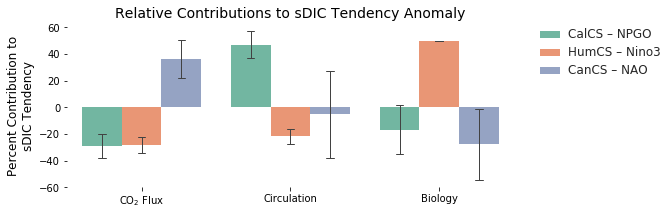

In [12]:
f, ax = plt.subplots(figsize=(8,3))

plt.style.use('seaborn-whitegrid')
clist = ['#66c2a5', '#fc8d62', '#8da0cb']

sns.barplot(x='variable', y='value', hue='system', data=df,
           ci='sd', capsize=0.05, errwidth=1, order=list(['co2', 'circ', 'bio']),
           palette=clist)

ax.set_xticklabels(['CO$_{2}$ Flux','Circulation','Biology'])
ax.set_xlabel('')
ax.set_ylabel('Percent Contribution to' + '\n' + 'sDIC Tendency', fontsize=12)
ax.set_title('Relative Contributions to sDIC Tendency Anomaly', fontsize=14)

sns.despine(left=True, bottom=True)
et.vis.outer_legend()
plt.setp(plt.gca().get_legend().get_texts(), fontsize=12)


#plt.show()
#et.vis.savefig('relative_sDIC_decomposition', extension='.eps', dpi=300)

### Actual Values

In [ ]:
def create_pandas(da, df, system):
    """
    da : dataarray to add to dataframe
    df : dataframe you are appending this to
    """
    temp_df = da.to_dataframe()
    temp_df.columns = ['value']
    temp_df['variable'] = da.name
    if system == 'CalCS':
        temp_df['system'] = system + ' – NPGO'
    elif system == 'CanCS':
        temp_df['system'] = system + ' – NAO'
    elif system == 'HumCS':
        temp_df['system'] = system + ' – Nino3'
    df = pd.concat([df, temp_df])
    return df

pairs = {'CalCS': 'NPGO', 'HumCS': 'nino3', 'CanCS': 'nao'}
df = pd.DataFrame()
for E, I in pairs.items():
    ds = load_variables(E)
    index = load_index(I)
    ds = xr.merge([ds, index])
    ds = ds.rename({I: 'index'})
    ds = regression(ds)
    conversion = 12 * total_area / 10**9
    ds = ds * conversion
    # Set up in Pandas
    df = create_pandas(ds['CO2'], df, E)
    df = create_pandas(ds['Biology'], df, E)
    df = create_pandas(ds['Circulation'], df, E)
    

In [ ]:
f, ax = plt.subplots(figsize=(8,3))
plt.style.use('seaborn-whitegrid')
clist = ['#66c2a5', '#fc8d62', '#8da0cb']


sns.barplot(x='variable', y='value', hue='system', data=df, ci='sd', capsize=0.05, errwidth=1,
            order=list(['CO2', 'Circulation', 'Biology']), palette=clist)


ax.set_xticklabels(['CO$_{2}$ Flux','Circulation','Biology'])
ax.set_xlabel('')
ax.set_ylabel('Contribution to' + '\n' + 'sDIC Tendency [GgC yr$^{-1}$]', fontsize=12)
ax.set_title('Absolute Contributions to sDIC Tendency Anomaly', fontsize=14)
ax.set_ylim([-1, 1])

sns.despine(left=True, bottom=True)
et.vis.outer_legend()
plt.setp(plt.gca().get_legend().get_texts(), fontsize=12)

#plt.show()
#et.vis.savefig('absolute_sDIC_decomposition', extension='.eps', dpi=300)